# Cancer Classification
### Michael Rizzo

# Part One
## First, we read in the data and drop all genes (rows) that contain NaN, as this will still leave us with a lot of data.

In [1]:
import pandas as pd
df = pd.read_csv("Genome_data.txt", sep="\t", index_col=0)
df.dropna(inplace=True)

## We then choose a random sample of 2000 genes (rows) and 50 patients (columns).

In [2]:
df = df.sample(n=2000)
df = df.sample(n=50, axis=1)

## We divide the genes into 20 clusters using K-Means.

In [3]:
from sklearn.cluster import KMeans
numClusters = 20
kmeans = KMeans(n_clusters=numClusters, random_state=0)
dpclusters = kmeans.fit(df)
centers = dpclusters.cluster_centers_
points = kmeans.predict(df)

## We show the 50 dimensional data of gene expression for each K-Means cluster using a parallel coordinates plot.  Each color represents a color, so we can see how the clustering was done based on gene expression.

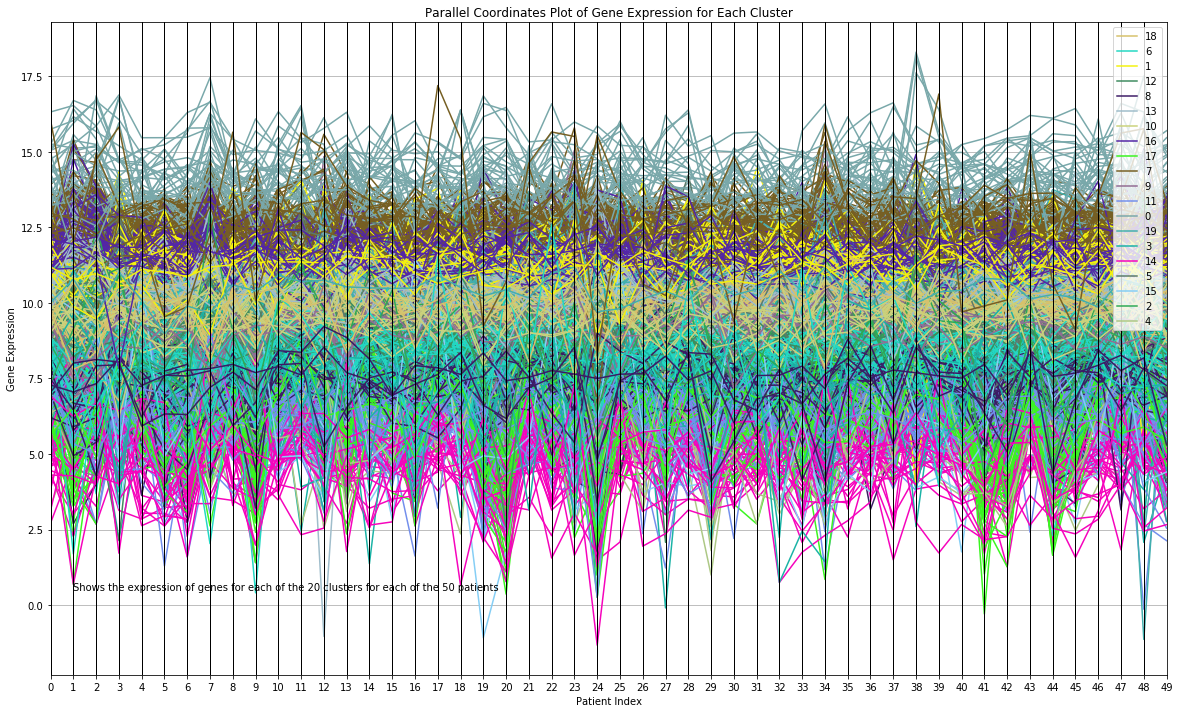

In [4]:
import matplotlib.pyplot as plt

df_with_clusters = df.copy(deep=True)
df_with_clusters.columns = range(0,50)
df_with_clusters['cluster'] = kmeans.labels_
plt.figure(figsize=(20,12))
plt.xlabel("Patient Index")
plt.ylabel("Gene Expression")
plt.title("Parallel Coordinates Plot of Gene Expression for Each Cluster")
plt.annotate("Shows the expression of genes for each of the 20 clusters for each of the 50 patients", (1,0.5))
pd.plotting.parallel_coordinates(df_with_clusters, 'cluster')
plt.show()

## The above plot is very messy.  Below, we have another parallel coordinates plot that shows the gene expression data, but only for the cluster centers.  While it shows less data, it is more readable and clearly shows how gene expression affected the clustering.

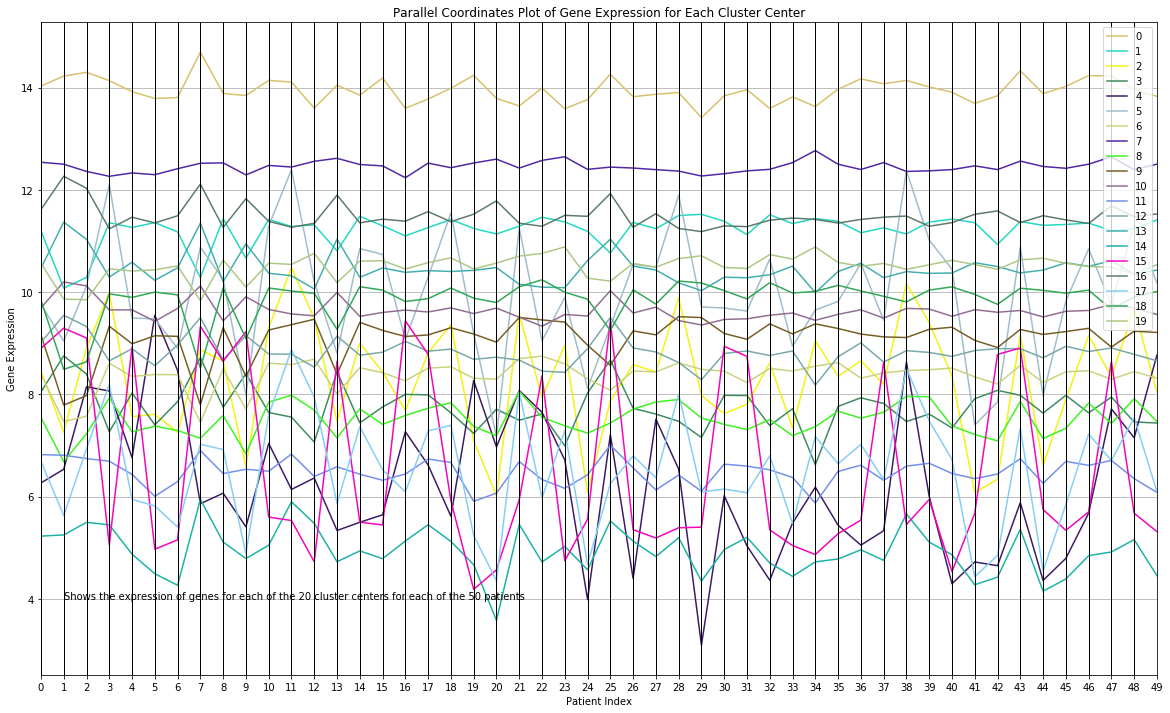

In [5]:
centersDf = pd.DataFrame(centers)
centersDf['cluster'] = range(0,20)
plt.figure(figsize=(20,12))
plt.xlabel("Patient Index")
plt.ylabel("Gene Expression")
plt.title("Parallel Coordinates Plot of Gene Expression for Each Cluster Center")
plt.annotate("Shows the expression of genes for each of the 20 cluster centers for each of the 50 patients", (1,4))
pd.plotting.parallel_coordinates(centersDf, 'cluster')
plt.show()

## We calculate and plot (in a histogram) the size of each cluster.

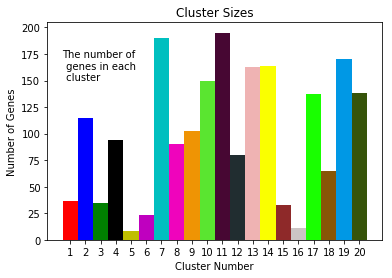

In [6]:
color_list = ['r','b','g','k','y','m','c','#ef04bc','#ef9404','#5ae530', '#470733','#212d30','#efb3b3','#faff00','#8e2929','#ccc5c5','#19ff00','#875506','#0098e5','#36540a']
axes = plt.subplot()
axes.set_xticklabels(range(1,21))
n, bins, patches = plt.hist(x=kmeans.labels_ + 1, bins=20)
for i in range(0, len(patches)):
    patches[i].set_facecolor(color_list[i])
plt.xticks(bins[:-1] + 0.475)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Genes")
plt.title("Cluster Sizes")
plt.annotate("The number of\n genes in each\n cluster", (1,150))
plt.show()

count = [0]*numClusters
for x in kmeans.labels_:
    count[x] = count[x] + 1

## We believe there should be less clusters, so each will have a larger number of data points, as some have very few.

## Now we plot the dendogram.

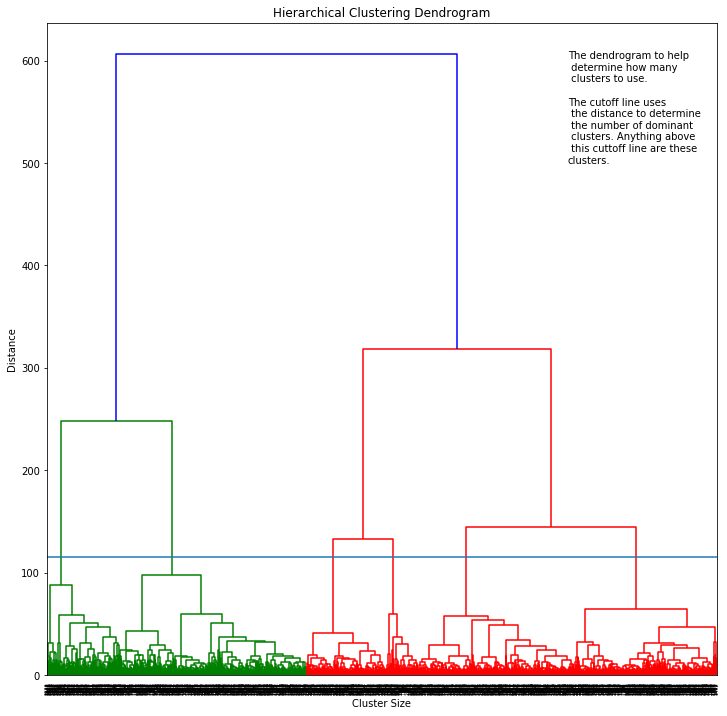

In [7]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
linkage = linkage(df, 'ward') 
plt.figure(figsize=(12,12))
dendrogram = dendrogram(linkage)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size") 
plt.ylabel("Distance")
plt.annotate("The dendrogram to help\n determine how many\n clusters to use.\n\nThe cutoff line uses\n the distance to determine\n the number of dominant\n clusters. Anything above \n this cuttoff line are these\nclusters.", (15550,500))
plt.axhline(y=115)
plt.show()

## We have six dominant clusters.

## We perform principal component analysis on the data.

In [8]:
from sklearn.decomposition import PCA
pca = PCA()
components = pca.fit_transform(df)

## We show how much of the variance in the data is explained by each principal component in two plots.  The first shows the amount of variance explained by each individual component.  The second shows the cumulative explained variance of the first x components.

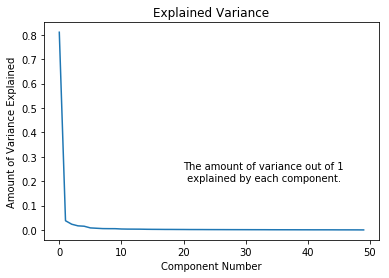

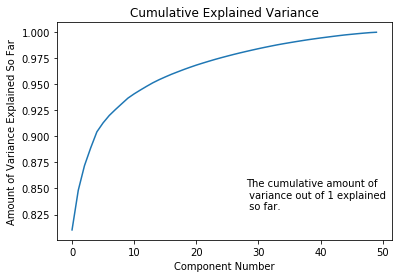

In [9]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Explained Variance")
plt.xlabel("Component Number")
plt.ylabel("Amount of Variance Explained")
plt.annotate("The amount of variance out of 1\n explained by each component.", (20,0.2))
plt.show()

cumulativeExplainedVarianceRatio = list()
currentExplainedVarianceRatio = 0
for i in range(0, len(pca.explained_variance_ratio_)):
    currentExplainedVarianceRatio += pca.explained_variance_ratio_[i]
    cumulativeExplainedVarianceRatio.append(currentExplainedVarianceRatio)

plt.plot(cumulativeExplainedVarianceRatio)
plt.title("Cumulative Explained Variance")
plt.xlabel("Component Number")
plt.ylabel("Amount of Variance Explained So Far")
plt.annotate("The cumulative amount of\n variance out of 1 explained\n so far.", (28,0.83))
plt.show()

### We would choose to use the first six components to compress the data, since these represent about 92% of the variance and each subsequent component represents very little more variance.
### We could even get away with just using the one first component, since it represents about 83% of the variance.
### It makes sense that so much of the variance would be contained in such a few components, since the patients are similar in that they have the same type of cancer.

# Part 2

## We read in the data for each of the two types of breast cancer and label each row accoring to the type.

## We then divide each into training and test data.  We combine the training data for each type and do the same for the test data.

In [10]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
mat = scipy.io.loadmat('CSE391_classificatin_project.mat')

X=mat["X"]
Y=mat["Y"]
X = X.transpose()
Y = Y.transpose()
X = pd.DataFrame(data=X)
Y = pd.DataFrame(data=Y)
X.loc[:,"Subtype"] = 0
Y.loc[:,"Subtype"] = 1

trainX, testX = train_test_split(X, test_size=0.2)
trainY, testY = train_test_split(Y, test_size=0.2)

frames = [trainX, trainY]
train = pd.concat(frames)
frames = [testX, testY]
test = pd.concat(frames)

## We perform SVM classification to identify each type of breast cancer.

In [11]:
X = train.iloc[:,:200]
Y = train["Subtype"]
X = np.array(X)
Y = np.array(Y)
clf = SVC()
clf.fit(X, Y)

testX = test.iloc[:,:200]
testX = np.array(testX)
Y2 = np.array(test["Subtype"])

RESULTINGPREDS=clf.predict(testX)
count = 0
matching = 0

## We show the results of svm classification using common metrics.

In [12]:
confusion = confusion_matrix(Y2, RESULTINGPREDS)
print("The accuracy of this model is:" , accuracy_score(Y2, RESULTINGPREDS))
print("The f1 score is:", f1_score(Y2, RESULTINGPREDS))
print("The log loss is:", log_loss(Y2, RESULTINGPREDS))
print("The FDR (false discovery rate) for X is:", confusion[0][1]/(confusion[0][0] + confusion[0][1]))
print("The FDR (false discovery rate) for Y is:", confusion[1][0]/(confusion[1][1] + confusion[1][0]))

The accuracy of this model is: 0.94
The f1 score is: 0.943396226415
The log loss is: 2.07237455954
The FDR (false discovery rate) for X is: 0.12
The FDR (false discovery rate) for Y is: 0.0


## We plot the confusion matrices to further see how accurate our classification was.  The first confusion matrix is not normalized, but the second one is.  We see that this is a very good model.  The genetic expression data for each type of breast cancer is very distinct.

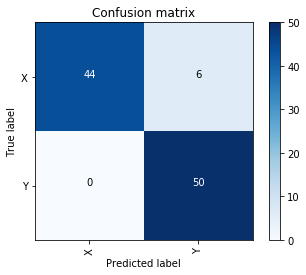

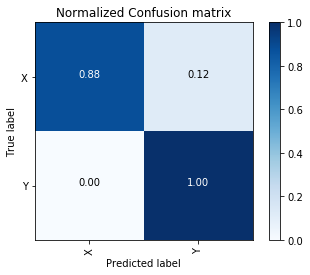

In [13]:
import itertools
# from the notes, slightly edited, and Justin's assignment 2
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure()
plot_confusion_matrix(confusion, ['X','Y'])

plt.figure()
plot_confusion_matrix(confusion, ['X','Y'], normalize=True, title="Normalized Confusion matrix")

plt.show()